# Analysing the MIT Supercloud dataset

The goal here is to analyze the MIT Supercloud Cluster dataset and convert the data to be used in the simulator [Batsim](https://batsim.readthedocs.io/en/latest/). Details about the data are available through this [link](https://dcc.mit.edu/data). Initially I will analyze the file `slurm-log.csv`.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_csv('slurm-log.csv')

In [3]:
df.head()

,id_job,id_array_job,id_array_task,id_user,kill_requid,nodes_alloc,nodelist,cpus_req,derived_ec,exit_code,gres_used,array_max_tasks,array_task_pending,constraints,flags,mem_req,partition,priority,state,timelimit,time_submit,time_eligible,time_start,time_end,time_suspended,track_steps,tres_alloc,tres_req,job_type
0,82691694838059,38873353215144,2504,42770088536256,61026541062099,1,['r9189566-n911952'],20,0,0,NaN,0,0,xeon-g6,4,9223372036854784308,normal,10237,3,4294967295,1609535703,1609535704,1609806297,1609806605,0,0,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20",OTHER
1,3434806870797,38873353215144,2523,42770088536256,61026541062099,1,['r9189566-n911952'],20,0,0,NaN,0,0,xeon-g6,4,9223372036854784308,normal,10237,3,4294967295,1609535703,1609535704,1609806607,1609807004,0,0,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20",OTHER
2,8370846758272,38873353215144,2543,42770088536256,61026541062099,1,['r9189566-n911952'],20,0,0,NaN,0,0,xeon-g6,4,9223372036854784308,normal,10237,3,4294967295,1609535703,1609535704,1609807004,1609807331,0,0,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20",OTHER
3,50552783599355,16618712154521,4294967294,28063009141185,61026541062099,1,['r2100214-n851693'],1,9,35072,NaN,0,0,xeon-g6,2,9223372036854784308,normal,110413,5,1440,1609807695,1609807695,1609807695,1609811546,0,0,"1=40,2=340000,4=1,5=40","1=1,2=8500,4=1,5=1",LLSUB:INTERACTIVE
4,16051179268048,74939912707152,2625,42770088536256,61026541062099,1,['r9189566-n911952'],20,0,0,NaN,0,0,xeon-g6,4,9223372036854784308,normal,10239,3,4294967295,1609535912,1609535912,1609808470,1609808777,0,0,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20",OTHER


In [4]:
df.columns

Index(['id_job', 'id_array_job', 'id_array_task', 'id_user', 'kill_requid',
       'nodes_alloc', 'nodelist', 'cpus_req', 'derived_ec', 'exit_code',
       'gres_used', 'array_max_tasks', 'array_task_pending', 'constraints',
       'flags', 'mem_req', 'partition', 'priority', 'state', 'timelimit',
       'time_submit', 'time_eligible', 'time_start', 'time_end',
       'time_suspended', 'track_steps', 'tres_alloc', 'tres_req', 'job_type'],
      dtype='object')

In [5]:
df[['partition', 'constraints']].value_counts()

partition  constraints 
normal     xeon-g6         192399
xeon-p8    \N              146174
normal     \N               42304
           xeon-g6&6248     14845
gaia       xeon-g6             82
test       xeon-e5             60
db         opteron             26
test       \N                  20
xeon-p8    xeon-p8              2
db         \N                   1
           opteron&6274         1
Name: count, dtype: int64

There are different partitions in the log. According to the [MIT website](https://supercloud.mit.edu/systems-and-software) only two partitions exist (or are available to users):
1. `xeon-g6-volta`, and
2. `xeon-p8`.

It appears (see [this PDF](https://supercloud.mit.edu/sites/default/files/documents/TX-E1_Reference_Guide.pdf)) that the `xeon-p8` partition contains the Intel Xeon Platinum 8260 CPUs, while the `normal` partition contains the Intel Xeon Gold 6248.

Based on this information I will make the following modifications:
- Remove the jobs where the partition is neither `normal` nor `xeon-p8`, i.e. `gaia`, `test` and `db` partitions;
- Drop the `constraints` column;
- Rename the remaining partitions to GPU available and CPU only (clearer names).

In [6]:
total_jobs = len(df)
partition_counts = df['partition'].value_counts()

fractions = partition_counts / total_jobs

print(f"Fractions of partitions:\n{fractions}")

Fractions of partitions:
partition
normal     0.630309
xeon-p8    0.369211
gaia       0.000207
test       0.000202
db         0.000071
Name: count, dtype: float64


Note that the removed partitions represent less than 0.001%.

In [7]:
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['partition'].isin(['normal', 'xeon-p8'])]
filtered_df = filtered_df.drop('constraints', axis=1)

In [8]:
filtered_df['partition'] = filtered_df['partition'].replace({'normal': 'GPU-avail', 'xeon-p8': 'CPU-only'})

In [9]:
filtered_df['job_type'].value_counts()

job_type
OTHER                266432
LLSUB:BATCH           96347
LLMAPREDUCE:MAP       25844
LLSUB:INTERACTIVE      7101
Name: count, dtype: int64

In [10]:
total_jobs = len(filtered_df)
job_type_counts = filtered_df['job_type'].value_counts()

fractions = job_type_counts / total_jobs

print(f"Fractions of job types:\n{fractions}")

Fractions of job types:
job_type
OTHER                0.673277
LLSUB:BATCH          0.243470
LLMAPREDUCE:MAP      0.065308
LLSUB:INTERACTIVE    0.017944
Name: count, dtype: float64


Jobs also vary by type. According to [this MIT page](https://supercloud.mit.edu/submitting-jobs) and looking at the existing types, I was able to conclude the following:
- There are two ways to submit jobs: by Slurm commands or by a `LLsub` wrapper command.
- The LLsub command can be run interactively or in batch.
- The LLMapReduce command runs identical parallel tasks, with a reduction step at the end (also batch-submitted).

This way we can conclude the following:
- The `LLSUB:*` types are jobs executed by the LLsub command and are split between interactive and batch.
- The `OTHER` type probably refers to jobs submitted directly by slurm commands.
- The `LLMAPREDUCE:MAP` type clearly refers to jobs submitted by the LLMapReduce command.

I propose here that interactive jobs have little relevance to our study. In general, these jobs are used for testing, debugging, and interactive analysis.

Based on this, here are some modifications:
- Remove interactive jobs (less than 2% of the filtered dataset);
- Remove the `job_type` column.

In [11]:
filtered_df = filtered_df[filtered_df['job_type'] != 'LLSUB:INTERACTIVE']
filtered_df = filtered_df.drop('job_type', axis=1)

In [12]:
filtered_df.head()

,id_job,id_array_job,id_array_task,id_user,kill_requid,nodes_alloc,nodelist,cpus_req,derived_ec,exit_code,gres_used,array_max_tasks,array_task_pending,flags,mem_req,partition,priority,state,timelimit,time_submit,time_eligible,time_start,time_end,time_suspended,track_steps,tres_alloc,tres_req
0,82691694838059,38873353215144,2504,42770088536256,61026541062099,1,['r9189566-n911952'],20,0,0,NaN,0,0,4,9223372036854784308,GPU-avail,10237,3,4294967295,1609535703,1609535704,1609806297,1609806605,0,0,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20"
1,3434806870797,38873353215144,2523,42770088536256,61026541062099,1,['r9189566-n911952'],20,0,0,NaN,0,0,4,9223372036854784308,GPU-avail,10237,3,4294967295,1609535703,1609535704,1609806607,1609807004,0,0,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20"
2,8370846758272,38873353215144,2543,42770088536256,61026541062099,1,['r9189566-n911952'],20,0,0,NaN,0,0,4,9223372036854784308,GPU-avail,10237,3,4294967295,1609535703,1609535704,1609807004,1609807331,0,0,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20"
4,16051179268048,74939912707152,2625,42770088536256,61026541062099,1,['r9189566-n911952'],20,0,0,NaN,0,0,4,9223372036854784308,GPU-avail,10239,3,4294967295,1609535912,1609535912,1609808470,1609808777,0,0,"1=20,2=170000,4=1,5=20","1=20,2=170000,4=1,5=20"
6,26419036762941,84173100828392,0,11289836447956,61026541062099,1,['r9535192-n386398'],1,0,0,NaN,0,0,4,9223372036854784308,GPU-avail,10771,3,4294967295,1609809099,1609809100,1609809100,1609809460,0,0,"1=1,2=8500,4=1,5=1","1=1,2=8500,4=1,5=1"


## Removing irrelevant columns

In Batsim, jobs must have the following fields:
1. `id`: Unique identifier of the job (string).
2. `subtime`: The submission time of the job (float, in seconds).
3. `res`: The number of requested resources (positive integer).
4. `profile`: The name of the profile associated with the job (string).

From the logs, it is possible to extract the first three pieces of information. The `profile` will be constructed from time series data, and its name is arbitrary. It makes sense to add a prefix before the identifier, e.g., `usage_<id>`.

Additional information can be included, and the most relevant one here is the `partition`. I will also include `runtime`, `walltime`, `cpus`, and `waittime`.

In [13]:
filtered_df['waittime'] = filtered_df['time_start'] - filtered_df['time_submit']
filtered_df['runtime'] = filtered_df['time_end'] - filtered_df['time_start']

filtered_df = filtered_df.rename(
    columns={
        'id_job': 'id',
        'time_submit': 'subtime',
        'nodes_alloc': 'res',
        'timelimit': 'walltime',
        'cpus_req': 'cpus'
    }
)

filtered_df['profile'] = 'usage_' + filtered_df['id'].astype(str)

filtered_df = filtered_df.loc[:, ['id', 'subtime', 'res', 'profile', 'partition', 'walltime', 'runtime', 'cpus', 'waittime']]

In [14]:
filtered_df.head()

,id,subtime,res,profile,partition,walltime,runtime,cpus,waittime
0,82691694838059,1609535703,1,usage_82691694838059,GPU-avail,4294967295,308,20,270594
1,3434806870797,1609535703,1,usage_3434806870797,GPU-avail,4294967295,397,20,270904
2,8370846758272,1609535703,1,usage_8370846758272,GPU-avail,4294967295,327,20,271301
4,16051179268048,1609535912,1,usage_16051179268048,GPU-avail,4294967295,307,20,272558
6,26419036762941,1609809099,1,usage_26419036762941,GPU-avail,4294967295,360,1,1


## Adding timeseries information

In a preliminary analysis of the time series, I identified some issues:
- Each job is associated with different `Steps` which in SLURM nomenclature, represent parallel tasks present in the script used to run the job;
    - Almost all jobs have a `batch` type step that is always associated with a single series;
    - Almost all jobs have a negative step `-1` or `-4`. The CPU usage data in these steps is always 0;
    - There are also positive steps (`0`, `1`, ...). The number of time series present is equal, or one less, to the number of nodes.
- There should be time series for each node allocated to each step. For some jobs this is not the case.
    - Some jobs have more than one series associated with a node.

In [15]:
def read_and_process_summary(id):
    try:
        summary = pd.read_csv(f'timeseries/{id}-summary.csv', usecols=['Step'], dtype={'Step': 'string'})
        summary = summary.sort_values(by='Step').reset_index(drop=True)
        steps = summary['Step'].unique().tolist()
        series = summary['Step'].value_counts().tolist()
        return {'id': id, 'steps': steps, 'series': series}
    except Exception as e:
        print(f"Error processing id={id}: {e}")
        return None

In [16]:
from multiprocessing import Pool, cpu_count

ids = filtered_df['id'].unique()

with Pool(cpu_count()) as pool:
    results = pool.map(read_and_process_summary, ids)

results = [r for r in results if r is not None]

target_df = pd.DataFrame(results)

In [22]:
final_df = pd.merge(filtered_df, target_df, on='id')
final_df.head()

,id,subtime,res,profile,partition,walltime,runtime,cpus,waittime,steps,series
0,82691694838059,1609535703,1,usage_82691694838059,GPU-avail,4294967295,308,20,270594,"[-1, batch]","[1, 1]"
1,3434806870797,1609535703,1,usage_3434806870797,GPU-avail,4294967295,397,20,270904,"[-1, batch]","[1, 1]"
2,8370846758272,1609535703,1,usage_8370846758272,GPU-avail,4294967295,327,20,271301,"[-1, batch]","[1, 1]"
3,16051179268048,1609535912,1,usage_16051179268048,GPU-avail,4294967295,307,20,272558,"[-1, batch]","[1, 1]"
4,26419036762941,1609809099,1,usage_26419036762941,GPU-avail,4294967295,360,1,1,"[-1, batch]","[1, 1]"


In [20]:
final_df['steps'].value_counts().head(10)

steps
[-4, batch]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    295546
[-1, batch]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

The vast majority of jobs are of the type:
- [-4, batch]
- [-1, batch]
- [-4, 0, batch]
- [-1, 0, batch]
- [-4, 0]

We will use this to filter the data. Let's exclude the type [-4, 0] for multi-node jobs, it will be easier to do the conversions.

In [26]:
valid_multinode_steps = [['-1', '0', 'batch'], ['-4', '0', 'batch']]
valid_singlenode_steps = [['-1', 'batch'], ['-4', 'batch'], ['-1', '0', 'batch'], ['-4', '0', 'batch'], ['-4', '0']]

# filter out invalid combinations of steps and res
final_df = final_df[( (final_df.res > 1) & (final_df.steps.isin(valid_multinode_steps)) ) | ( (final_df.res == 1) & (final_df.steps.isin(valid_singlenode_steps)) )]
final_df['steps'].value_counts()

steps
[-4, batch]       294919
[-1, batch]        69623
[-4, 0, batch]     12809
[-4, 0]             7352
[-1, 0, batch]      2057
Name: count, dtype: int64

I believe that with this information it is already possible to collect the series and convert them to the Batsim format.

In [32]:
final_df.to_csv('scheduler-log-batsim-ready.csv', index=False)

## Analyzing the distribution of execution time and walltime

The operation of this platform sets the walltime as unlimited. Therefore, this field may be less relevant for the analyses. However, time limits have been assigned to some jobs (see distributions below).

Thus, jobs not marked as unlimited (`walltime` != 4294967295) will have the `walltime` included.

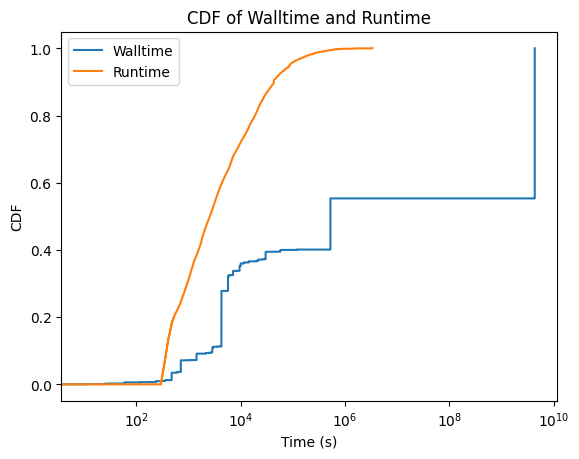

In [30]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create the ECDF objects
ecdf_walltime = sm.distributions.ECDF(final_df['walltime'])
ecdf_runtime = sm.distributions.ECDF(final_df['runtime'])

# Plot the ECDFs
plt.step(ecdf_walltime.x, ecdf_walltime.y, label='Walltime')
plt.step(ecdf_runtime.x, ecdf_runtime.y, label='Runtime')

# Set the plot labels
plt.xlabel('Time (s)')
plt.ylabel('CDF')
plt.title('CDF of Walltime and Runtime')

# Set the x-axis to log scale
plt.xscale('log')

# Add legend
plt.legend()

# Show the plot
plt.show()